# Pipeline - Kildisuite Neuroblastoma Data

In [237]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.stats import ranksums
import statistics

In [238]:
def ReadFiles():
    # Read the h5ad file for neuroblastoma data
    nb_data = sc.read_h5ad("/Users/davidkaplan/Desktop/neuroblastoma_data/kildisuite/nb_GOSH_cellxgene.h5ad")

    #Read the h5ad file for adrenal gland data
    ag_data = sc.read_h5ad("/Users/davidkaplan/Desktop/neuroblastoma_data/kildisuite/adr_all_cellxgene.h5ad")


    return nb_data, ag_data

In [239]:
def QualityControlMetrics(data):
    sns.set(style="darkgrid")
    print(data.obs.columns)
    data.var['mt'] = data.var_names.str.startswith('MT-')
    sc.pp.calculate_qc_metrics(data,qc_vars=['mt'],percent_top=None,log1p=False,inplace=True)
    fig, axes = plt.subplots(1,3,figsize=(12,4))
    sns.boxplot(data.obs['n_genes_by_counts'],ax=axes[0])
    sns.boxplot(data.obs['nCount_RNA'],ax=axes[1])
    sns.boxplot(data.obs['pct_counts_mt'],ax=axes[2])
    sc.pl.violin(data,['nFeature_RNA','n_genes_by_counts','total_counts','nCount_RNA','pct_counts_mt'],jitter=0.4,multi_panel=True)
    sc.pl.scatter(data,x='nCount_RNA',y='n_genes_by_counts',color='pct_counts_mt')
    sns.distplot(data.obs['n_genes_by_counts'])
    sns.jointplot(y="n_genes_by_counts",x="nCount_RNA",data=data.obs,kind="scatter",s=5)
    
    return data

In [240]:
def n_genes_filter(data):
    upper = np.quantile(data.obs.n_genes_by_counts.values, .98)
    lower = np.quantile(data.obs.n_genes_by_counts.values, .02)
    median = statistics.median(data.obs.n_genes_by_counts)
    MAD = data.obs.n_genes_by_counts.mad()
    lowMAD = median - (3*MAD)
    highMAD = median + (3*MAD)
    
    print("Range: "+str(lowMAD)+" to "+str(highMAD))
    
    print("Range: "+str(lower)+" to "+str(upper))
    #data = data[(data.obs.n_genes_by_counts < upper) & (data.obs.n_genes_by_counts > lower)]
    return data

In [241]:
def OcasioMitoFiltering(data):
    #Version 1 - Ocasio et al., 2019
    median = statistics.median(data.obs.pct_counts_mt)
    print(median)
    sd = statistics.stdev(data.obs.pct_counts_mt)
    upper_lim = median + (sd * 3)
    lower_lim = median - (sd* 3)
    if lower_lim < 0:
        lower_lim = 0
    print("Range: "+str(lower_lim)+" to "+str(upper_lim))
    data = data[data.obs.pct_counts_mt < upper_lim, :]
    return data

In [242]:
def YouMitoFiltering(data):
    # Version 2 - You et al., 2021
    median = statistics.median(data.obs.pct_counts_mt)
    med = data.obs.pct_counts_mt.median()
    MAD = data.obs.pct_counts_mt.mad()
    print(med,MAD)
    filter_mt = (median + (3*MAD))
    print("Upper",filter_mt)
    data = data[data.obs.pct_counts_mt < filter_mt, :]
    return data

In [243]:
def FilteringCheck(data):
    sc.pl.scatter(data,x='nCount_RNA',y='n_genes_by_counts',color='pct_counts_mt')

In [244]:
def Main():
    nb_data,ag_data = ReadFiles()
    print(ag_data.shape)
    processed_data = []
    datasets = [nb_data,ag_data]
    for i,dataset in enumerate(datasets):
        data = QualityControlMetrics(dataset)
        data = n_genes_filter(data)
        if i == 1:
            data = YouMitoFiltering(data)
            FilteringCheck(data)
        processed_data.append(data)
    
    nb_data = processed_data[0]
    ag_data = processed_data[1]
            

(57972, 33694)
Index(['SampleName', 'Annotation', 'nCount_RNA', 'nFeature_RNA', 'mtGenes',
       'hspGenes', 'riboGenes'],
      dtype='object')


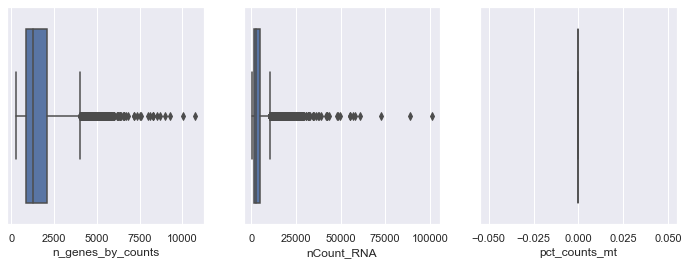

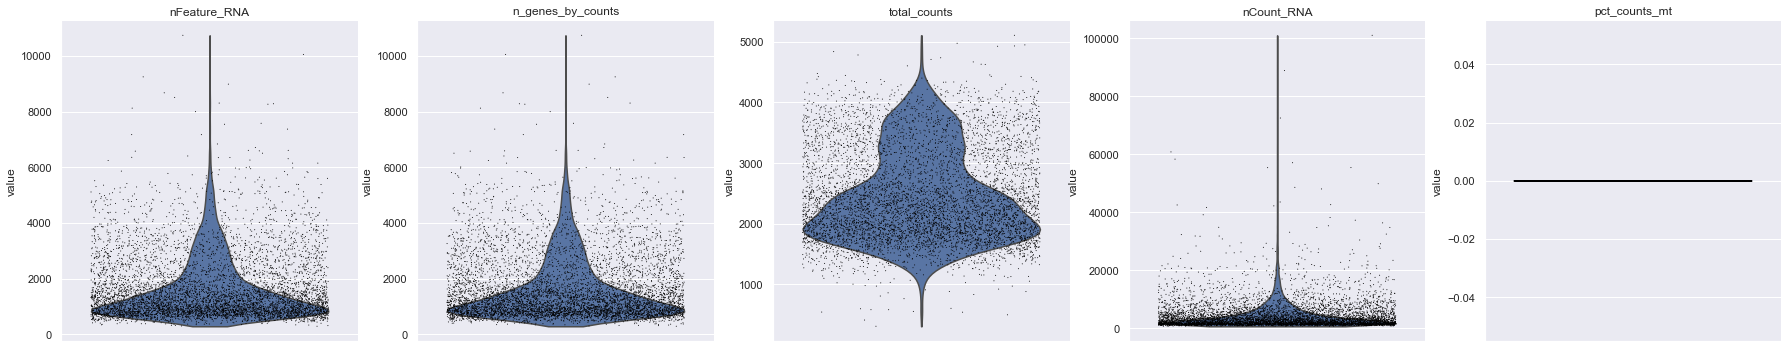

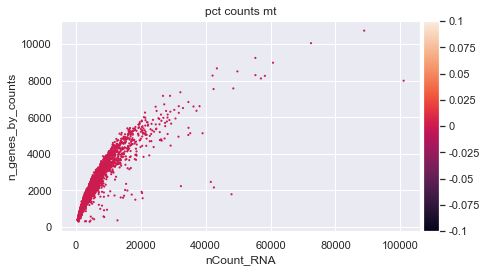

Range: -1357.8745811140625 to 3859.8745811140625
Range: 509.82 to 4957.700000000004
Index(['GestationalAge', 'SampleName', 'Annotation', 'nCount_RNA',
       'nFeature_RNA', 'mtGenes', 'hspGenes', 'riboGenes'],
      dtype='object')


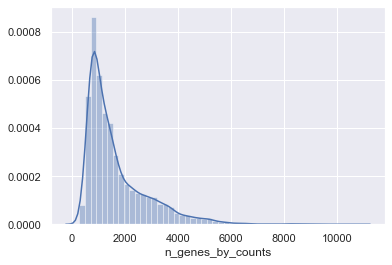

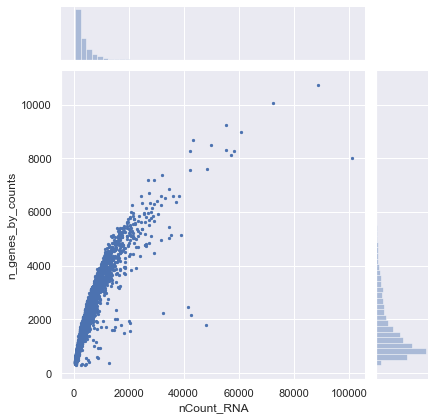

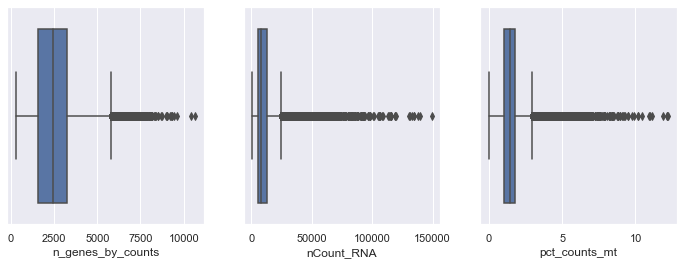

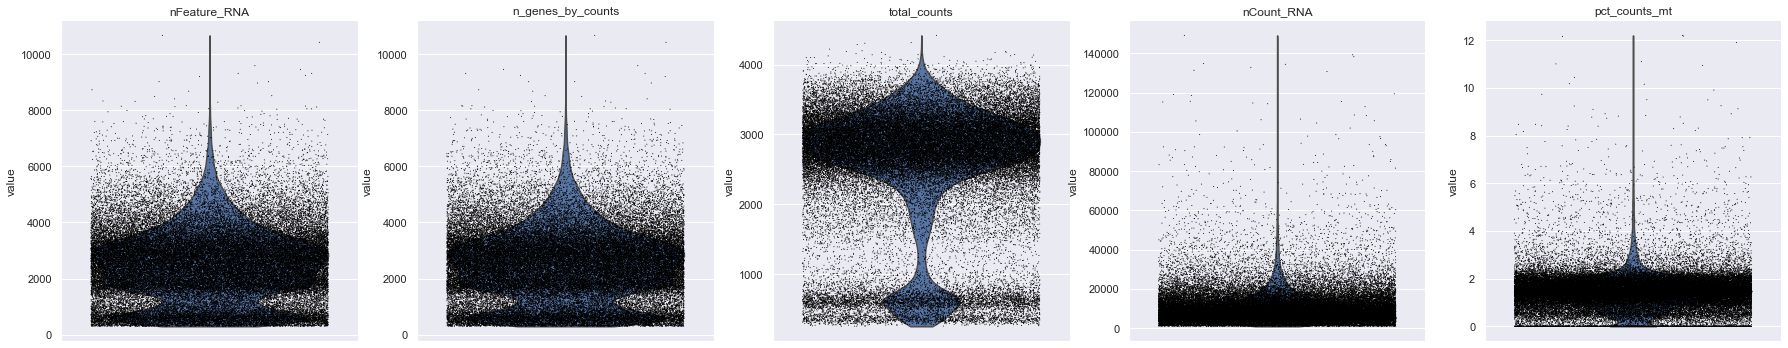

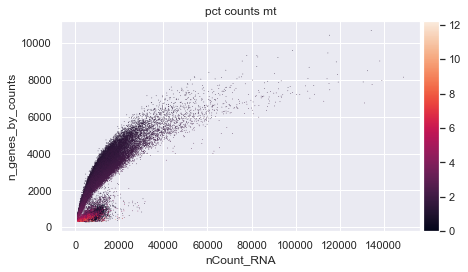

Range: -627.257120958172 to 5549.257120958172
Range: 384.0 to 5408.0
1.4421005 0.514275
Upper 2.9849255681037903


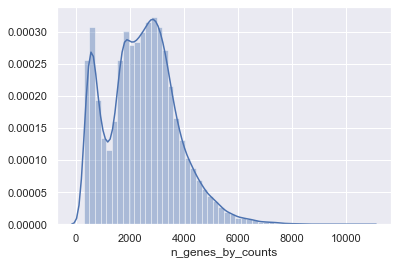

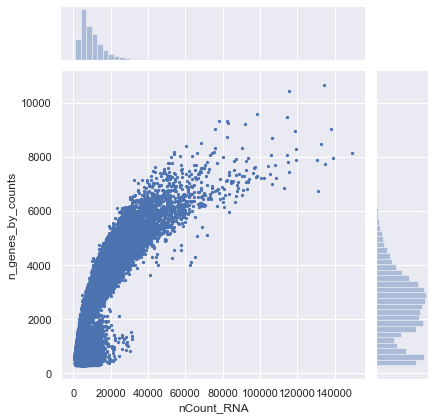

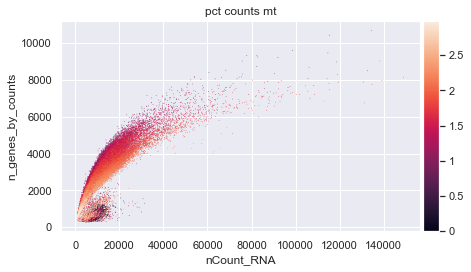

In [245]:
Main()